In [27]:
# ライブラリのインポート
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import seaborn as sns; sns.set()
import warnings 
warnings.filterwarnings('ignore')
import lightgbm as lgb #LightGBM
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

import joblib

import lightgbm as lgb

import sklearn.metrics


In [195]:
test_data = pd.read_json('datasets/rcqa/test.jsonl', orient='records', lines=True)
#test_data = pd.read_json('datasets/rcqa/val.jsonl', orient='records', lines=True)
test_data.head()

,qid,competition,timestamp,format,question,answer,title,text,score,did
0,11333,abc_08,2010-03-21,早押し,ファッションショーにおいてモデルが歩く、客席に突き出したステージのことを何というでしょう?,キャットウォーク,ランウェイ,ランウェイ (runway) あるいはキャットウォーク (catwalk) とは、ファッショ...,4,1
1,11333,abc_08,2010-03-21,早押し,ファッションショーにおいてモデルが歩く、客席に突き出したステージのことを何というでしょう?,キャットウォーク,Prism Stone,2012年3月30日、パシフィコ横浜で行われたタカラトミー主催のイベント「プリティーガールズ...,1,2
2,11333,abc_08,2010-03-21,早押し,ファッションショーにおいてモデルが歩く、客席に突き出したステージのことを何というでしょう?,キャットウォーク,仙台コレクション,屋内で開催される同種のリアル・クローズのファッションショーで見られる出展ブランドの特設直販ブ...,0,3
3,11333,abc_08,2010-03-21,早押し,ファッションショーにおいてモデルが歩く、客席に突き出したステージのことを何というでしょう?,キャットウォーク,ファッションショー,ファッションショーでは、予め選ばれたモデルが売り手側が用意した服を着て、観客席に挟まれた細長...,4,4
4,11333,abc_08,2010-03-21,早押し,ファッションショーにおいてモデルが歩く、客席に突き出したステージのことを何というでしょう?,キャットウォーク,マンチカン,体長より少しばかり短い、動作豊かな尻尾を持つ。片足をもう一方の足と同じ直線上に置きつつ、尻尾...,0,5


In [142]:
dataset = {}
for name in ['train', 'val', 'test']:
    x1 = joblib.load(f'datasets/rcqa/{name}_qa_emb.npy.pickle')
    x2 = joblib.load(f'datasets/rcqa/{name}_passage_emb.npy.pickle')
    y = joblib.load(f'datasets/rcqa/{name}_rcqa_score.npy.pickle')

    X = np.concatenate([x1, x2], axis=1)
    del x1, x2

    dataset[name] = {
        'X': X,
        'y': y
    }


In [143]:
X_train, y_train = dataset['train']['X'], dataset['train']['y']
X_val, y_val = dataset['val']['X'], dataset['val']['y']
X_test, y_test = dataset['test']['X'], dataset['test']['y']

X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((45371, 1536), (45371, 1), (5736, 1536), (5736, 1), (5544, 1536), (5544, 1))

In [144]:
from sklearn import utils

X_train, y_train = utils.shuffle(X_train, y_train)

In [145]:
model = lgb.LGBMRegressor() # モデルのインスタンスの作成
model.fit(X_train, y_train) # モデルの学習

# テストデータの予測
y_pred = model.predict(X_test)

KeyboardInterrupt: 

In [93]:
mean_squared_error(y_test, y_pred)

2.79025542306934

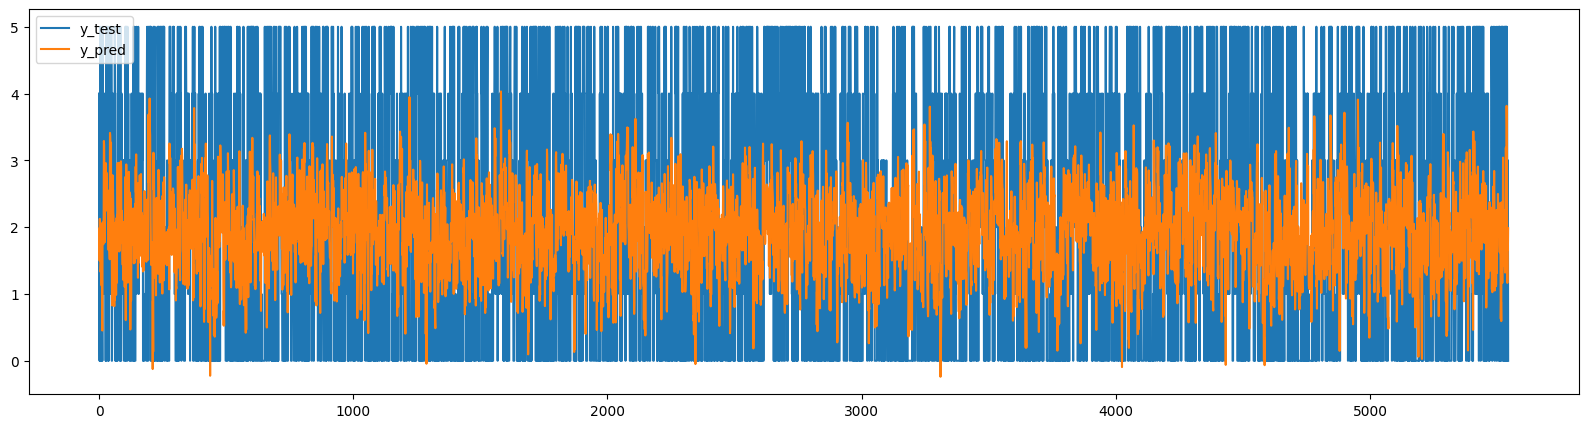

In [94]:
plt.figure(figsize=(20, 5))
plt.plot(y_test, label="y_test")
plt.plot(y_pred, label="y_pred")
plt.legend()


In [95]:
r2_score(y_test, y_pred)

0.1997614163414213

In [96]:
# 学習に使用するデータを設定
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train) 

# LightGBM parameters
params = {
        'task': 'train',
        'boosting_type': 'gbdt',
        'objective': 'regression',
        'metric': {'rmse'}, 
}

# モデルの学習
model = lgb.train(params,
                  train_set=lgb_train,
                  valid_sets=lgb_eval,
                  num_boost_round=1000
                  )

# テストデータの予測
y_pred = model.predict(X_test)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.412394 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 391680
[LightGBM] [Info] Number of data points in the train set: 45371, number of used features: 1536
[LightGBM] [Info] Start training from score 1.899958
[1]	valid_0's rmse: 1.85972
[2]	valid_0's rmse: 1.85381
[3]	valid_0's rmse: 1.84829
[4]	valid_0's rmse: 1.84267
[5]	valid_0's rmse: 1.83795
[6]	valid_0's rmse: 1.83365
[7]	valid_0's rmse: 1.83006
[8]	valid_0's rmse: 1.82615
[9]	valid_0's rmse: 1.82312
[10]	valid_0's rmse: 1.81841
[11]	valid_0's rmse: 1.81545
[12]	valid_0's rmse: 1.81305
[13]	valid_0's rmse: 1.80951
[14]	valid_0's rmse: 1.8061
[15]	valid_0's rmse: 1.80296
[16]	valid_0's rmse: 1.79976
[17]	valid_0's rmse: 1.79638
[18]	valid_0's rmse: 1.79315
[19]	valid_0's rmse: 1.78985
[20]	valid_0's rmse: 1.78712
[21]	valid_0's rmse: 1.78436
[22]	valid_0's rmse: 1.78222
[23]	valid_0's rmse: 1.

KeyboardInterrupt: 

In [118]:
mean_squared_error(y_test, y_pred), r2_score(y_test, y_pred)

(2.79025542306934, 0.1997614163414213)

Text(0.5, 0, 'y (RCQA score)')

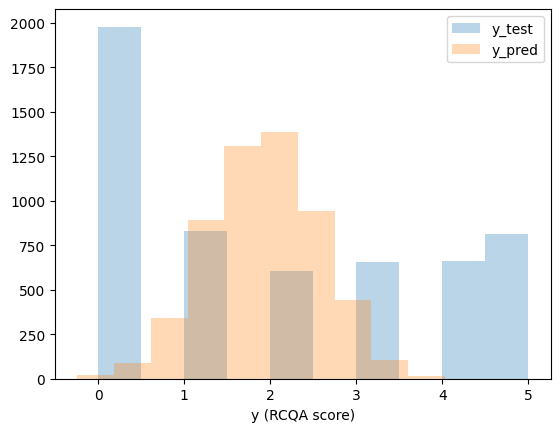

In [119]:
plt.hist(y_test, alpha=0.3, label='y_test')
plt.hist(y_pred, alpha=0.3, label='y_pred')
plt.legend();
plt.xlabel('y (RCQA score)')

In [ ]:
break

# bert-classificationの結果整理

- test_dataでなくval_dataのgold, pred を出していた。n_epochを小さくして、testまで回す
- gold, predの順序と val_data の順序が違う？ラベルが合わない。dataloaderのn_workers > 1 のせい?

In [196]:
# 途中epochで中断した結果 accuracy, precision, recall, f1 それぞれ 0.40かそれを若干切る程度
gold = pd.read_csv('gold_labels', header=None).iloc[:, 0].values.astype('int')
pred = pd.read_csv('pred_labels', header=None).iloc[:, 0].values.astype('int')

# accuracy
(gold == pred).sum() / len(gold)

0.476010101010101

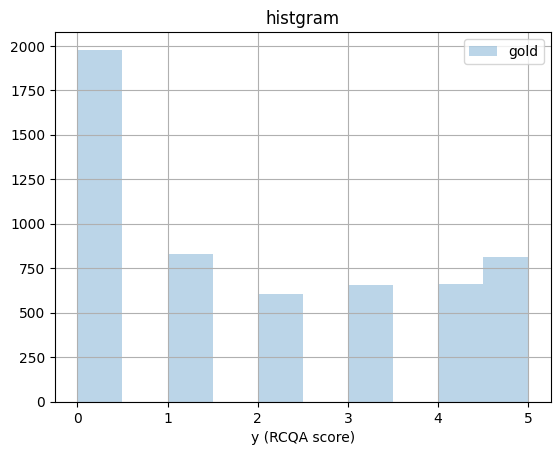

In [197]:
plt.hist(gold, alpha=0.3, label='gold')
plt.title('histgram')
plt.xlabel('y (RCQA score)')
plt.legend()
plt.grid()

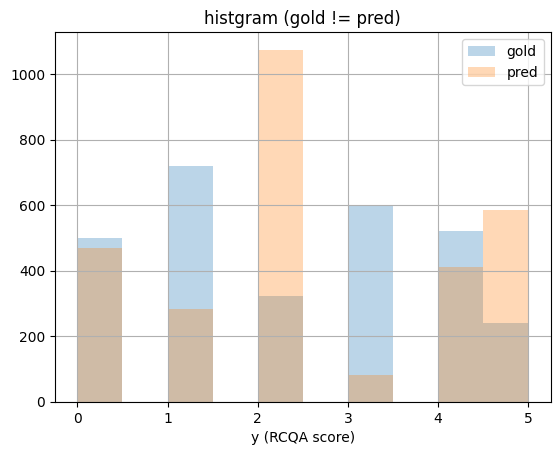

In [198]:
plt.hist(gold[gold != pred], alpha=0.3, label='gold')
plt.hist(pred[gold != pred], alpha=0.3, label='pred')
plt.title('histgram (gold != pred)')
plt.xlabel('y (RCQA score)')
plt.legend()
plt.grid()

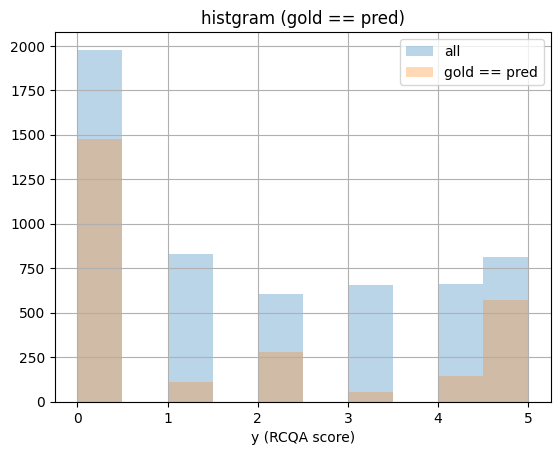

In [199]:
plt.hist(gold, alpha=0.3, label='all')
plt.hist(gold[gold == pred], alpha=0.3, label='gold == pred')
plt.title('histgram (gold == pred)')
plt.xlabel('y (RCQA score)')
plt.legend()
plt.grid()

In [200]:
sklearn.metrics.accuracy_score(gold, pred)

0.476010101010101

In [201]:
# マイクロ平均での評価指標
sklearn.metrics.precision_score(gold, pred, average='micro'),  sklearn.metrics.recall_score(gold, pred, average='micro'), sklearn.metrics.f1_score(gold, pred, average='micro')

(0.476010101010101, 0.476010101010101, 0.476010101010101)

In [202]:
# マクロ平均での評価指標
sklearn.metrics.precision_score(gold, pred, average='macro'),  sklearn.metrics.recall_score(gold, pred, average='macro'), sklearn.metrics.f1_score(gold, pred, average='macro')

(0.4020741750670249, 0.391661755850264, 0.3630932330726715)

In [203]:
# 混同行列
sklearn.metrics.confusion_matrix( gold, pred)
# 行 gold, 列 pred

array([[1478,  163,  289,    4,   27,   17],
       [ 323,  111,  306,   11,   43,   36],
       [  88,   69,  279,   23,   76,   68],
       [  32,   37,  226,   57,  138,  168],
       [  19,   10,  169,   24,  144,  298],
       [   6,    4,   85,   19,  127,  570]])

大きく予測を間違うものは何か特徴があるだろう。(gold =5, pred=0 や gold=0, pred=5のケース)

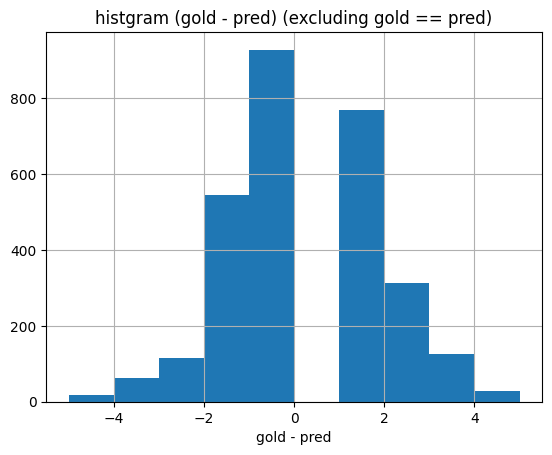

In [204]:
plt.hist(gold[gold != pred] - pred[gold != pred])
plt.xlabel('gold - pred')
plt.title('histgram (gold - pred) (excluding gold == pred)')
plt.grid()

↑予測誤差はきれいなベルカーブに見える。予測誤差が小さな場合が多いので、二値判定であれば問題ない可能性がある。

In [205]:
# 予測ラベル差が +/-0
(abs(gold - pred) < 1).sum(), (abs(gold - pred) < 1).sum() / len(gold)

(2639, 0.476010101010101)

In [206]:
# 予測ラベル差が +/-1以内
(abs(gold - pred) < 2).sum(), (abs(gold - pred) < 2).sum() / len(gold)

(4336, 0.7821067821067821)

In [207]:
# 予測ラベル差が +/-2以内
(abs(gold - pred) < 3).sum(), (abs(gold - pred) < 3).sum() / len(gold)

(5193, 0.9366883116883117)

In [208]:
# https://alaginrc.nict.go.jp/nict-bert/Experiments_on_RCQA.html
# スコア2以上か否かの二値分類に
gold_b, pred_b  =  gold > 1, pred > 1

In [209]:
sklearn.metrics.accuracy_score(gold_b, pred_b)

0.81998556998557

In [210]:
# マイクロ平均での評価指標
sklearn.metrics.precision_score(gold_b, pred_b, average='micro'),  sklearn.metrics.recall_score(gold_b, pred_b, average='micro'), sklearn.metrics.f1_score(gold_b, pred_b, average='micro')

(0.81998556998557, 0.81998556998557, 0.81998556998557)

In [211]:
# マクロ平均での評価指標
sklearn.metrics.precision_score(gold_b, pred_b, average='macro'),  sklearn.metrics.recall_score(gold_b, pred_b, average='macro'), sklearn.metrics.f1_score(gold_b, pred_b, average='macro')

(0.8289878037069048, 0.8210516944069576, 0.8190624190624192)

In [212]:
# 混同行列
sklearn.metrics.confusion_matrix(gold_b, pred_b)
# 行 gold, 列 pred

array([[2075,  733],
       [ 265, 2471]])

In [213]:
test_data['pred'] = pred
test_data['gold'] = gold

In [214]:
# 予測が極端に異なるもの goldが高いものは予測を的中させたい
test_data[(abs(gold - pred) > 3)]

,qid,competition,timestamp,format,question,answer,title,text,score,did,pred,gold
66,11347,abc_08,2010-03-21,早押し,カメラのレンズとボディを接合する部分を、特に何というでしょう?,マウント,レンズマウント,カメラボディのレンズマウント規格とレンズのボディマウント規格が一致しないときに、両者を仲立ち...,0,4,5,0
105,11355,abc_08,2010-03-21,早押し,有名な時計ブランドのフランク・ミュラー、タグ・ホイヤー、スウォッチといえば、どこの国のもので...,スイス,エタ (時計),ブライトリング、クロノスイス、フランク・ミュラー、フォルティス、ハミルトン、インターナショナ...,0,4,5,0
172,11372,abc_08,2010-03-21,早押し,デリーからバスだけでロンドンに向かう旅行体験を綴った、バックパッカーのバイブル的存在である沢...,深夜特急,斎藤工,高校時代、ノンフィクション作家、沢木耕太郎の『深夜特急』に影響され、海外に1人で出かけるよう...,4,4,0,4
252,11390,abc_08,2010-03-21,早押し,室町時代に起こった応仁の乱で、東軍の大将は細川勝元ですが、西軍の大将は誰でしょう?,山名宗全,竹田城,応仁元年(1467年)、細川勝元と山名宗全の争いが一因で応仁の乱が起こると但馬は細川氏と山名...,4,3,0,4
352,11413,abc_08,2010-03-21,早押し,左右で一対と数える人間の肋骨は、全部で何対あるでしょう?,12対,東峰十字路事件,事件後行われた司法解剖の結果、死亡した3名の機動隊員のうち小隊長の福島誠一は、頭蓋骨亀裂骨折...,4,4,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...
5423,12564,EQIDEN_2010,2010-03-21,早押し,バドワイザーはアメリカのビールですが、ハイネケンはどこの国のビールでしょう?,オランダ,ブランズビール,ブランドビール()は、オランダのリンブルフ州のビールブランド。日本語ではブランズビールとも書...,1,3,5,1
5450,12571,EQIDEN_2010,2010-03-21,早押し,従来型のテレビの画面なら4:3、ハイビジョンテレビの画面なら16:9となる、2次元の形状の物...,アスペクト比,ノートパソコン,軽量化およびバッテリー動作のため、表示機器には主に液晶ディスプレイが使われており、基本的に本...,0,3,5,0
5487,12579,EQIDEN_2010,2010-03-21,早押し,百分率のことを「パーセント」といいますが、百万分率のことを何というでしょう?,ppm,無次元量,このような無次元量の一貫性のある組立単位は数の1である。実用上は数値を扱い易くするために、百...,1,1,5,1
5537,12590,EQIDEN_2010,2010-03-21,早押し,ドミニカ国の首都はロゾーですが、ドミニカ共和国の首都はどこでしょう?,サント・ドミンゴ,サントドミンゴ,サント・ドミンゴは、1844年2月27日に、ドミニカ人が国民的英雄に率いられ、ハイチの支配か...,0,4,5,0


In [215]:
# 予測が極端に異なるもの goldが高いものは予測を的中させたい
test_data[(abs(gold - pred) > 3)].sort_values(by='score', ascending=False)

,qid,competition,timestamp,format,question,answer,title,text,score,did,pred,gold
4809,12431,EQIDEN_2010,2010-03-21,早押し,赤い目を持ちお酒に近寄る習性があることから伝説上の生き物の名前が付けられた、モーガンの遺伝研...,ショウジョウバエ,トーマス・ハント・モーガン,モーガンの研究以前は、遺伝子はあくまで抽象的な存在であった。染色体説の実証により、染色体上に...,5,3,1,5
601,11468,abc_08,2010-03-21,早押し,1642年にニュージーランドを発見したオランダの航海士で、オーストラリア最大の島にもその名を...,アベル・タスマン,タスマン (小惑星),タスマニア島、ニュージーランド、フィジー等を発見したオランダの探検家アベル・タスマンに因んで...,5,4,1,5
1637,11705,abc_08,2010-03-21,早押し,モナコ公国と極めてよく似たデザインの国旗をもつ、東南アジアの国はどこでしょう?,インドネシア,モナコ,国旗のデザインが国連基準の2:3の縦横比になるとインドネシアと同様になるため、両国の間で調整...,5,4,0,5
2466,11896,abc_08,2010-03-21,早押し,今年1月に開催されたラグビー全国大学選手権で、決勝で東海大学を破り初優勝を果たした大学はどこ...,帝京大学,第46回全国大学ラグビーフットボール選手権大会,第46回全国大学ラグビーフットボール選手権大会は2009年12月20日から2010年1月10...,5,2,0,5
3655,12174,abc_08,2010-03-21,早押し,1963年には『アラバマ物語』でアカデミー主演男優賞を受賞している、『ローマの休日』における...,グレゴリー・ペック,ローマの休日,新聞記者をグレゴリー・ペック、王女をオードリー・ヘプバーンが演じている。この時に新人だったオ...,5,2,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...
3257,12085,abc_08,2010-03-21,早押し,グルジア語で「こんにちは」という意味がある、赤いモヒカンのケッチ!と黄色いモヒカンのHIRO...,が〜まるちょば,が〜まるちょば,「が〜まるちょば」とは、カルトリ語で「こんにちは」(、)の意味。,0,2,4,0
3276,12090,abc_08,2010-03-21,早押し,その独特の化粧法は瞼譜と呼ばれる、北京を中心に発展した中国の伝統演劇は何でしょう?,京劇,曹操,京劇でも曹操は悪役として扱われ、瞼譜(隈取)も悪役のそれ(二皮)である。,0,4,4,0
3336,12104,abc_08,2010-03-21,早押し,別名を「シロバナムシヨケギク」という、ピレトリンという成分を含むため殺虫剤の原料に使用される...,除虫菊,殺虫剤,その後、カラバル豆の有毒なアルカロイド成分であるフィゾスチグミンを参考にして有機リン系と同様...,0,3,4,0
3337,12104,abc_08,2010-03-21,早押し,別名を「シロバナムシヨケギク」という、ピレトリンという成分を含むため殺虫剤の原料に使用される...,除虫菊,ピレスロイド,"ピレスロイド (pyrethroid) とは、除虫菊 (""Tanacetum cinerar...",0,4,4,0


In [216]:
# goldとpredが極端に異なる question-answer-passage の一例について、他のpassageを含めた一覧
qid = np.random.choice(test_data[(abs(gold - pred) > 3) & (gold == 5)].qid)
test_data[test_data.qid == qid]

,qid,competition,timestamp,format,question,answer,title,text,score,did,pred,gold
2465,11896,abc_08,2010-03-21,早押し,今年1月に開催されたラグビー全国大学選手権で、決勝で東海大学を破り初優勝を果たした大学はどこ...,帝京大学,第46回全国大学ラグビーフットボール選手権大会,決勝は東海大学と帝京大学で争われ、14-13の1点差で帝京大学が東海大学を降して初優勝を果た...,5,1,5,5
2466,11896,abc_08,2010-03-21,早押し,今年1月に開催されたラグビー全国大学選手権で、決勝で東海大学を破り初優勝を果たした大学はどこ...,帝京大学,第46回全国大学ラグビーフットボール選手権大会,第46回全国大学ラグビーフットボール選手権大会は2009年12月20日から2010年1月10...,5,2,0,5
2467,11896,abc_08,2010-03-21,早押し,今年1月に開催されたラグビー全国大学選手権で、決勝で東海大学を破り初優勝を果たした大学はどこ...,帝京大学,伊東秀剛,長崎県立長崎東高等学校卒業後、帝京大学に入学。同大学4年時に大学ラグビー選手権で優勝を経験。...,1,3,0,1
2468,11896,abc_08,2010-03-21,早押し,今年1月に開催されたラグビー全国大学選手権で、決勝で東海大学を破り初優勝を果たした大学はどこ...,帝京大学,第50回全国大学ラグビーフットボール選手権大会,第50回全国大学ラグビーフットボール選手権大会は2013年11月9日から2014年1月12日...,1,4,0,1
2469,11896,abc_08,2010-03-21,早押し,今年1月に開催されたラグビー全国大学選手権で、決勝で東海大学を破り初優勝を果たした大学はどこ...,帝京大学,第51回全国大学ラグビーフットボール選手権大会,第51回全国大学ラグビーフットボール選手権大会は2014年11月16日から2015年1月10...,1,5,0,1


In [217]:
# goldとpredが極端に異なる question-answer-passage の一例について、他のpassageを含めた一覧
qid = np.random.choice(test_data[(abs(gold - pred) > 3) & (gold == 0)].qid)
test_data[test_data.qid == qid]

,qid,competition,timestamp,format,question,answer,title,text,score,did,pred,gold
3273,12090,abc_08,2010-03-21,早押し,その独特の化粧法は瞼譜と呼ばれる、北京を中心に発展した中国の伝統演劇は何でしょう?,京劇,川劇,京劇と似た様式で行われる中国の伝統的演劇であるが、変臉(へんれん)と呼ばれる、瞬時に瞼譜(隈...,1,1,4,1
3274,12090,abc_08,2010-03-21,早押し,その独特の化粧法は瞼譜と呼ばれる、北京を中心に発展した中国の伝統演劇は何でしょう?,京劇,化粧,俳優は、舞台に立つ時は、独特の化粧をする。たとえば、目・鼻筋・口などが遠くからでもはっきり判...,2,2,0,2
3275,12090,abc_08,2010-03-21,早押し,その独特の化粧法は瞼譜と呼ばれる、北京を中心に発展した中国の伝統演劇は何でしょう?,京劇,隈取,隈取(くまどり)とは、歌舞伎独特の化粧法のことである。初代市川團十郎が、坂田金時 の息子であ...,3,3,0,3
3276,12090,abc_08,2010-03-21,早押し,その独特の化粧法は瞼譜と呼ばれる、北京を中心に発展した中国の伝統演劇は何でしょう?,京劇,曹操,京劇でも曹操は悪役として扱われ、瞼譜(隈取)も悪役のそれ(二皮)である。,0,4,4,0
3277,12090,abc_08,2010-03-21,早押し,その独特の化粧法は瞼譜と呼ばれる、北京を中心に発展した中国の伝統演劇は何でしょう?,京劇,豫劇,豫劇(よげき)は、中国の伝統的な古典演劇である戯曲(歌劇の一種)の一つである。京劇、評劇、越...,2,5,0,2


In [218]:
# goldとpredが極端に異なる question-answer-passage を列挙
test_data[(abs(gold - pred) > 3)].qid.value_counts()

11997    3
12050    2
12230    2
11619    2
11733    2
        ..
11724    1
11723    1
11705    1
11689    1
12591    1
Name: qid, Length: 97, dtype: int64

1183

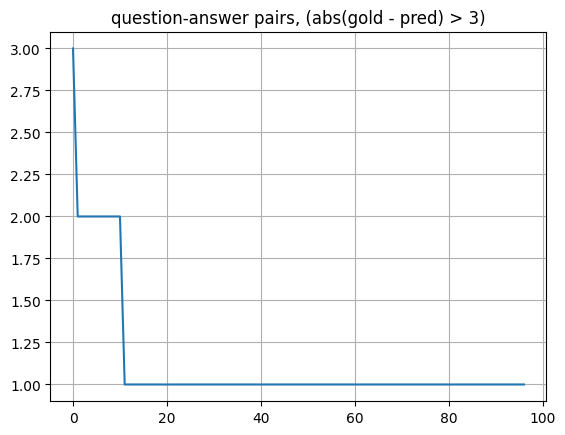

In [219]:
# goldとpredが極端に異なる question-answer-passage を列挙して頻度分布
plt.plot(test_data[(abs(gold - pred) > 3)].qid.value_counts().values)
plt.grid()
plt.title('question-answer pairs, (abs(gold - pred) > 3)')
len(test_data.qid.unique())

In [220]:
# goldとpredが極端に異なる question-answer-passage の top-1
qid = test_data[(abs(gold - pred) > 3)].qid.value_counts().keys()[0]
test_data[test_data.qid == qid]

,qid,competition,timestamp,format,question,answer,title,text,score,did,pred,gold
2882,11997,abc_08,2010-03-21,早押し,JR山手線の駅で、目白駅があるのは豊島区ですが、目黒駅があるのは何区でしょう?,品川区,洗足,東急目黒線洗足駅がある。目黒線の駅では唯一目黒区に所在する駅である。隣接する西小山駅(品川区...,0,1,5,0
2883,11997,abc_08,2010-03-21,早押し,JR山手線の駅で、目白駅があるのは豊島区ですが、目黒駅があるのは何区でしょう?,品川区,東急目黒線,目黒線を名乗っているが、目黒区を走行する区間は短く、同区に所在する駅は洗足駅のみ(大岡山駅は...,5,2,5,5
2884,11997,abc_08,2010-03-21,早押し,JR山手線の駅で、目白駅があるのは豊島区ですが、目黒駅があるのは何区でしょう?,品川区,目黒 (目黒区),また、JR目黒駅を根拠とした汎称地名としても使われ、JR目黒駅が品川区上大崎にあるため、この...,5,3,5,5
2885,11997,abc_08,2010-03-21,早押し,JR山手線の駅で、目白駅があるのは豊島区ですが、目黒駅があるのは何区でしょう?,品川区,西小山駅,西小山駅(にしこやまえき)は、東京都品川区小山六丁目にある東京急行電鉄目黒線の駅である。品川...,1,4,5,1
2886,11997,abc_08,2010-03-21,早押し,JR山手線の駅で、目白駅があるのは豊島区ですが、目黒駅があるのは何区でしょう?,品川区,白金桟道橋,白金桟道橋(しろかねさんどうばし)は、東京都品川区上大崎2丁目のJR東日本山手線および山手貨...,0,5,5,0


In [221]:
# goldとpredが極端に異なる question-answer-passage の top-2
qid = test_data[(abs(gold - pred) > 3)].qid.value_counts().keys()[1]
test_data[test_data.qid == qid]

,qid,competition,timestamp,format,question,answer,title,text,score,did,pred,gold
3105,12050,abc_08,2010-03-21,早押し,国土交通省にある4つの外局とは、海上保安庁、気象庁、観光庁と何でしょう?,運輸安全委員会,国土交通省,行政機関定員令に定められた国土交通省の定員は特別職を含めて5万7763人である。本省及び各外...,1,1,5,1
3106,12050,abc_08,2010-03-21,早押し,国土交通省にある4つの外局とは、海上保安庁、気象庁、観光庁と何でしょう?,運輸安全委員会,国土交通省,一般職の在職者数は2011年1月15日現在、国土交通省全体で6万728人(うち、女性5169...,1,2,5,1
3107,12050,abc_08,2010-03-21,早押し,国土交通省にある4つの外局とは、海上保安庁、気象庁、観光庁と何でしょう?,運輸安全委員会,海難審判庁,2008年10月1日、懲戒処分業務を国土交通省の特別の機関たる海難審判所に、事故原因究明事務...,0,3,2,0
3108,12050,abc_08,2010-03-21,早押し,国土交通省にある4つの外局とは、海上保安庁、気象庁、観光庁と何でしょう?,運輸安全委員会,航空・鉄道事故調査委員会,2008年10月1日、国土交通省の外局たる運輸安全委員会に改組された。,1,4,2,1
3109,12050,abc_08,2010-03-21,早押し,国土交通省にある4つの外局とは、海上保安庁、気象庁、観光庁と何でしょう?,運輸安全委員会,航空事故,日本では、1974年から国土交通省の審議会のひとつである航空・鉄道事故調査委員会(事故調)が...,2,5,2,2
